## Setup and load data

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Setup
tf.keras.utils.set_random_seed(42)

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# Load dataset
df = pd.read_csv('/content/files/IMDB Dataset.csv')

# Convert labels to binary (positive=1, negative=0)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split into train and test sets (80/20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['review'].values, train_df['sentiment'].values))
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['review'].values, test_df['sentiment'].values))

BUFFER_SIZE = 10000
BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create text encoder
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

print(f"Dataset loaded and processed")
print(f"Vocabulary size: {len(encoder.get_vocabulary())}")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

Dataset loaded and processed
Vocabulary size: 10000
Training samples: 40000
Testing samples: 10000


## Pretrained Glove Embeddings

In [2]:
EMBEDDING_DIM = 100
use_pretrained_embeddings = False
embedding_matrix = None

try:
    embeddings_index = {}
    with open(f'/content/files/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f'Loaded {len(embeddings_index)} word vectors from GloVe')

    # Create embedding matrix
    vocab = encoder.get_vocabulary()
    embedding_matrix = np.zeros((len(vocab), EMBEDDING_DIM))

    for i, word in enumerate(vocab):
        embedding_vector = embeddings_index.get(word.lower())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))

    found_words = len([w for w in vocab if w.lower() in embeddings_index])
    coverage = found_words / len(vocab) * 100
    print(f'Embedding matrix shape: {embedding_matrix.shape}')
    print(f'Vocabulary coverage: {coverage:.2f}% ({found_words}/{len(vocab)} words)')
    use_pretrained_embeddings = True

except Exception as e:
    print(f"Could not load GloVe embeddings: {e}")
    print("Using random embeddings instead.")
    use_pretrained_embeddings = False

Loaded 400000 word vectors from GloVe
Embedding matrix shape: (10000, 100)
Vocabulary coverage: 96.96% (9696/10000 words)


## Model Comparison Function

In [3]:
def build_model(model_type='lstm', bidirectional=False, use_pretrained=False):
    model = tf.keras.Sequential()
    model.add(encoder)

    if use_pretrained and embedding_matrix is not None:
        embedding_layer = tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=EMBEDDING_DIM,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=True,
            mask_zero=True
        )
        print(f"Using pretrained GloVe embeddings ({EMBEDDING_DIM}d)")
    else:
        embedding_layer = tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=128,
            mask_zero=True
        )
        print(f"Using random embeddings (128d)")

    model.add(embedding_layer)
    model.add(tf.keras.layers.Dropout(0.2))

    # Build RNN layer
    if model_type == 'simple_rnn':
        rnn_layer = tf.keras.layers.SimpleRNN(64, return_sequences=False)
        print(f"Using SimpleRNN")
    elif model_type == 'gru':
        rnn_layer = tf.keras.layers.GRU(64, return_sequences=False)
        print(f"Using GRU")
    else:  # lstm
        rnn_layer = tf.keras.layers.LSTM(64, return_sequences=False)
        print(f"Using LSTM")

    if bidirectional:
        rnn_layer = tf.keras.layers.Bidirectional(rnn_layer)
        print(f"Using Bidirectional")

    model.add(rnn_layer)
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    return model


## Model Comparison

In [4]:

EPOCHS = 3

models_to_train = [
    ('Simple RNN', 'simple_rnn', False, False),
    ('LSTM', 'lstm', False, False),
    ('GRU', 'gru', False, False),
    ('Bidirectional LSTM', 'lstm', True, False),
    ('LSTM with GloVe', 'lstm', False, True),
    ('Bidirectional LSTM with GloVe', 'lstm', True, True)
]

histories = {}
models = {}

for name, model_type, bidirectional, use_pretrained in models_to_train:
    print(f"Training: {name}")

    model = build_model(model_type, bidirectional, use_pretrained)

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy']
    )

    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=test_dataset,
        validation_steps=30,
        verbose=1
    )

    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    histories[name] = history
    models[name] = model

Training: Simple RNN
Using random embeddings (128d)
Using SimpleRNN
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 267s 841ms/step - accuracy: 0.5019 - loss: 0.6944 - val_accuracy: 0.4951 - val_loss: 0.6912
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 218s 695ms/step - accuracy: 0.5090 - loss: 0.6854 - val_accuracy: 0.4951 - val_loss: 0.6695
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 216s 689ms/step - accuracy: 0.5851 - loss: 0.6147 - val_accuracy: 0.8336 - val_loss: 0.3864
Test Accuracy: 0.8371, Test Loss: 0.3812
Training: LSTM
Using random embeddings (128d)
Using LSTM
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.5065 - loss: 0.6866 - val_accuracy: 0.8138 - val_loss: 0.4154
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.8477 - loss: 0.3645 - val_accuracy: 0.8906 - val_loss: 0.2671
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.9063 - loss: 0.2483 - val_accuracy: 0.9036 - val_loss: 0.2636
Test Accuracy: 0.8994, Test Loss: 0.2614
Training: GRU

## Visualization

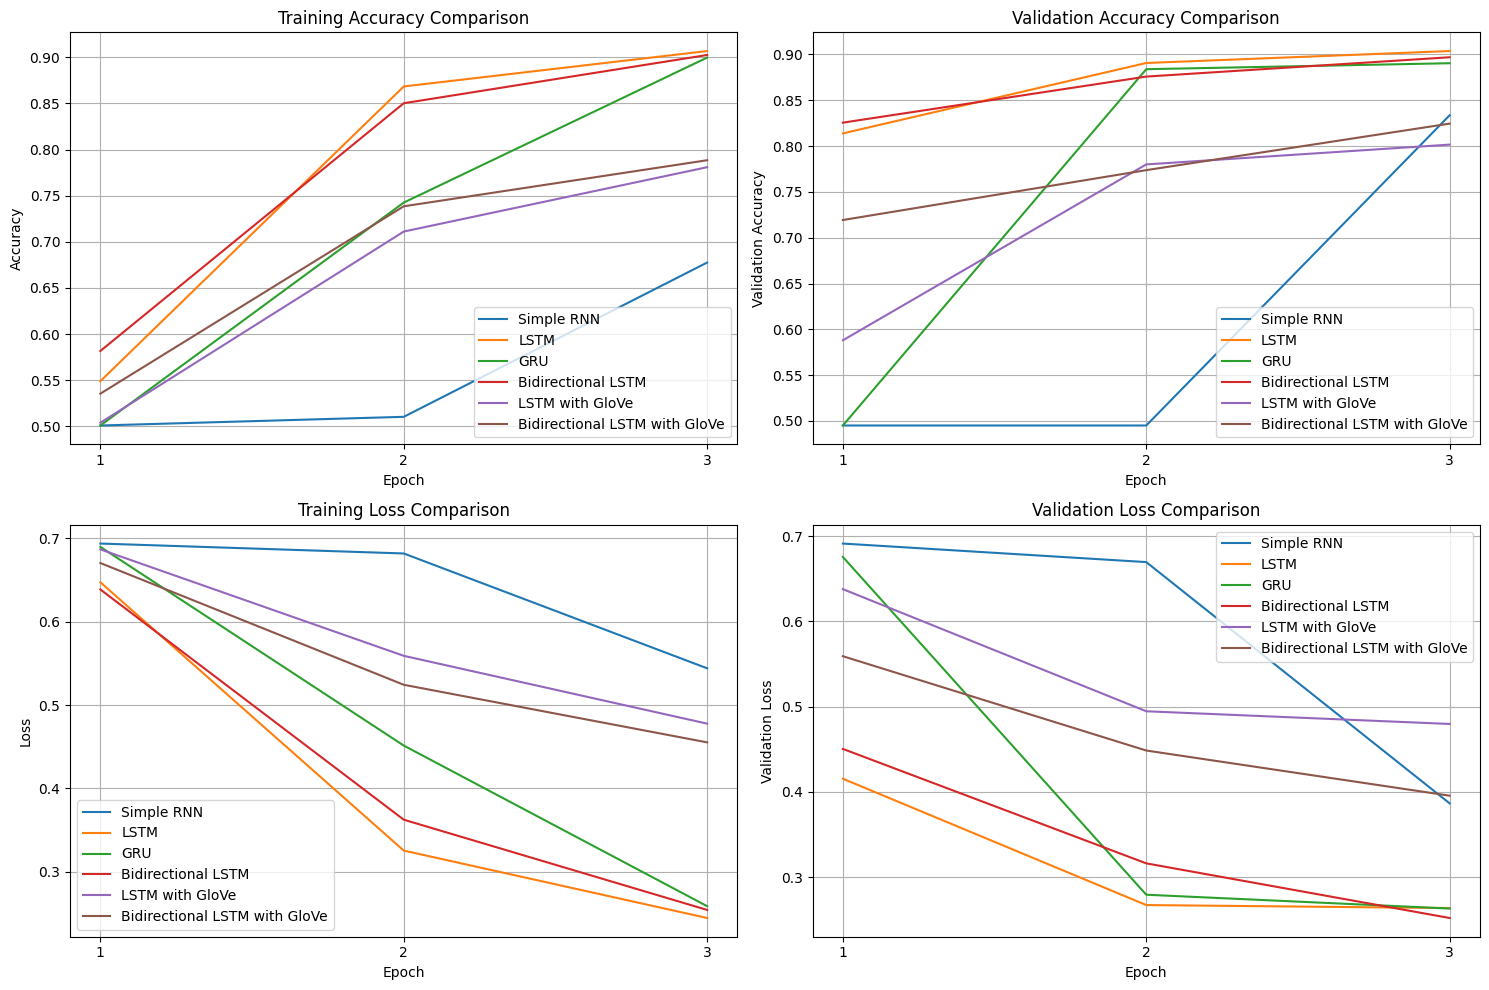

In [5]:
# Plot accuracy comparison
plt.figure(figsize=(15, 10))

# Plot 1: Accuracy comparison
plt.subplot(2, 2, 1)
for name, history in histories.items():
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], label=name)
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

# Plot 2: Validation accuracy comparison
plt.subplot(2, 2, 2)
for name, history in histories.items():
    epochs = range(1, len(history.history['val_accuracy']) + 1)
    plt.plot(epochs, history.history['val_accuracy'], label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

# Plot 3: Loss comparison
plt.subplot(2, 2, 3)
for name, history in histories.items():
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], label=name)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

# Plot 4: Validation loss comparison
plt.subplot(2, 2, 4)
for name, history in histories.items():
    epochs = range(1, len(history.history['val_loss']) + 1)
    plt.plot(epochs, history.history['val_loss'], label=name)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.tight_layout()
plt.show()

## Final results

In [6]:
print("\n{:<30} {:<12} {:<12}".format("Model", "Test Acc", "Test Loss"))
print("-" * 54)

for name, model in models.items():
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    print("{:<30} {:<12.4f} {:<12.4f}".format(name, test_acc, test_loss))


Model                          Test Acc     Test Loss   
------------------------------------------------------
Simple RNN                     0.8371       0.3812      
LSTM                           0.8994       0.2614      
GRU                            0.8931       0.2613      
Bidirectional LSTM             0.8945       0.2527      
LSTM with GloVe                0.8042       0.4691      
Bidirectional LSTM with GloVe  0.8234       0.3943      


## Test with sample texts

In [7]:
best_model_name = None
best_accuracy = 0

for name, model in models.items():
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model_name = name

print(f"Best model: {best_model_name}")

test_texts = [
    ("The movie was absolutely fantastic! The acting was superb and the story was captivating.", "Positive"),
    ("This was the worst movie I've ever seen. Terrible plot and awful acting.", "Negative"),
    ("I loved the cinematography and the soundtrack was amazing. Highly recommended!", "Positive"),
    ("Complete waste of time. Boring from start to finish.", "Negative")
]

print(f"Testing with: {best_model_name}\n")

best_model = models[best_model_name]

for text, true_label in test_texts:
    prediction = best_model.predict(tf.constant([text]), verbose=0)
    probability = tf.sigmoid(prediction).numpy()[0][0]

    if prediction[0][0] >= 0:
        pred_label = "POSITIVE"
    else:
        pred_label = "NEGATIVE"

    print(f"Text: {text[:80]}...")
    print(f"True Sentiment: {true_label}")
    print(f"Predicted: {pred_label} (Score: {prediction[0][0]:.4f}, Probability to be positive: {probability:.2%})")
    print(f"Correct: {'yes' if (pred_label == 'POSITIVE' and true_label == 'Positive') or (pred_label == 'NEGATIVE' and true_label == 'Negative') else 'no'}")

Best model: LSTM
Testing with: LSTM

Text: The movie was absolutely fantastic! The acting was superb and the story was capt...
True Sentiment: Positive
Predicted: POSITIVE (Score: 1.5376, Probability to be positive: 82.31%)
Correct: yes
Text: This was the worst movie I've ever seen. Terrible plot and awful acting....
True Sentiment: Negative
Predicted: NEGATIVE (Score: -3.9266, Probability to be positive: 1.93%)
Correct: yes
Text: I loved the cinematography and the soundtrack was amazing. Highly recommended!...
True Sentiment: Positive
Predicted: POSITIVE (Score: 2.9124, Probability to be positive: 94.85%)
Correct: yes
Text: Complete waste of time. Boring from start to finish....
True Sentiment: Negative
Predicted: NEGATIVE (Score: -2.8747, Probability to be positive: 5.34%)
Correct: yes
